# Exploratory Data Analysis (EDA) - Data Science

- Steps:
    - Understand the dataset - assess the quality of the dataset
    - Distribute of the dataset - How does the data look like?
    - Correlactions - Find patterns in the dataset

In [65]:
###############################################################
################### DATA CLEANING #############################
###############################################################

In [66]:
#!pip install pandas-profiling

In [67]:
import pandas                   as pd
import sys
import itertools
from collections               import Counter
import numpy                   as np
import gc # Garbage Collector interface
import feather
import time
from datetime                  import datetime
import matplotlib.pyplot       as plt
import seaborn                 as sns
from sklearn.feature_selection import mutual_info_classif
import plotly.express          as ex
from matplotlib                import pyplot

from sklearn.preprocessing     import OneHotEncoder
from sklearn.preprocessing     import LabelEncoder

from pandas_profiling          import ProfileReport

# Normality tests
from scipy.stats import normaltest

%matplotlib inline

plt.rcParams['figure.figsize'] = (20, 20)

##### >>> https://towardsdatascience.com/a-straightforward-guide-to-cleaning-and-preparing-data-in-python-8c82f209ae33
# source dataset: https://www.dataquest.io/blog/machine-learning-preparing-data/

# data cleaning - sources
# https://medium.com/sciforce/data-cleaning-and-preprocessing-for-beginners-25748ee00743
# https://medium.com/bitgrit-data-science-publication/data-cleaning-with-python-f6bc3da64e45
# https://towardsdatascience.com/the-ultimate-guide-to-data-cleaning-3969843991d4
# https://towardsdatascience.com/data-cleaning-and-feature-engineering-the-underestimated-parts-of-machine-learning-10681dae4cf7

# Pandas has a high consume of memory RAM usage
# release memory RAM
def release_memory(df):   
    del df
    gc.collect() 
    df = pd.DataFrame() # point to NULL
    print('memory RAM released.')

# Get start time 
start_time = time.time()

# datetime object containing current date and time
now = datetime.now()

# dd/mm/YY H:M:S
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print(">>> date: ", dt_string)

>>> date:  05/08/2021 22:28:51


## Quick Dataset Overview

In [68]:
# dataframe - df
# read csv file, the columns are separated (sep) by ','
df = pd.read_csv('../data/lending_club_loans.csv')
df

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,application_type,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,0.00,Jan-15,171.62,Jan-17,0.0,INDIVIDUAL,0.0,0,0.0,0.0
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,1.11,Apr-13,119.66,Oct-16,0.0,INDIVIDUAL,0.0,0,0.0,0.0
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,0.00,Jun-14,649.91,Jan-17,0.0,INDIVIDUAL,0.0,0,0.0,0.0
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,0.00,Jan-15,357.48,Apr-16,0.0,INDIVIDUAL,0.0,0,0.0,0.0
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,0.00,Jan-17,67.30,Jan-17,0.0,INDIVIDUAL,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39781,92187,92174,2500,2500,1075.0,36 months,8.07%,78.42,A,A4,...,0.00,Jul-10,80.90,Jun-10,NaN,INDIVIDUAL,NaN,0,NaN,NaN
39782,90665,90607,8500,8500,875.0,36 months,10.28%,275.38,C,C1,...,0.00,Jul-10,281.94,Jul-10,NaN,INDIVIDUAL,NaN,0,NaN,NaN
39783,90395,90390,5000,5000,1325.0,36 months,8.07%,156.84,A,A4,...,0.00,Apr-08,0.00,Jun-07,NaN,INDIVIDUAL,NaN,0,NaN,NaN
39784,90376,89243,5000,5000,650.0,36 months,7.43%,155.38,A,A2,...,0.00,Jan-08,0.00,Jun-07,NaN,INDIVIDUAL,NaN,0,NaN,NaN


In [69]:
print(f'Number of rows.....................: {df.shape[0]}')
print(f'Number of columns..................: {df.shape[1]}')

Number of rows.....................: 39786
Number of columns..................: 47


In [70]:
# % of rows missing in each column
list_columns_nan = list()

for column in df.columns:
    percentage = df[column].isnull().mean()
    if(percentage != 0):
        print(f'{column}: {round(percentage*100, 2)}%')
        list_columns_nan.append(column)

emp_length: 2.71%
revol_util: 0.13%
last_pymnt_d: 0.18%
last_credit_pull_d: 0.01%
collections_12_mths_ex_med: 0.14%
chargeoff_within_12_mths: 0.14%
pub_rec_bankruptcies: 1.75%
tax_liens: 0.1%


## Identify Missing Data

In [71]:
# count NaN found in the dataset
df.isna().sum()

id                               0
member_id                        0
loan_amnt                        0
funded_amnt                      0
funded_amnt_inv                  0
term                             0
int_rate                         0
installment                      0
grade                            0
sub_grade                        0
emp_length                    1078
home_ownership                   0
annual_inc                       0
verification_status              0
issue_d                          0
loan_status                      0
pymnt_plan                       0
zip_code                         0
addr_state                       0
dti                              0
delinq_2yrs                      0
earliest_cr_line                 0
inq_last_6mths                   0
open_acc                         0
pub_rec                          0
revol_bal                        0
revol_util                      50
total_acc                        0
initial_list_status 

## Missing value per feature - heatmap

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

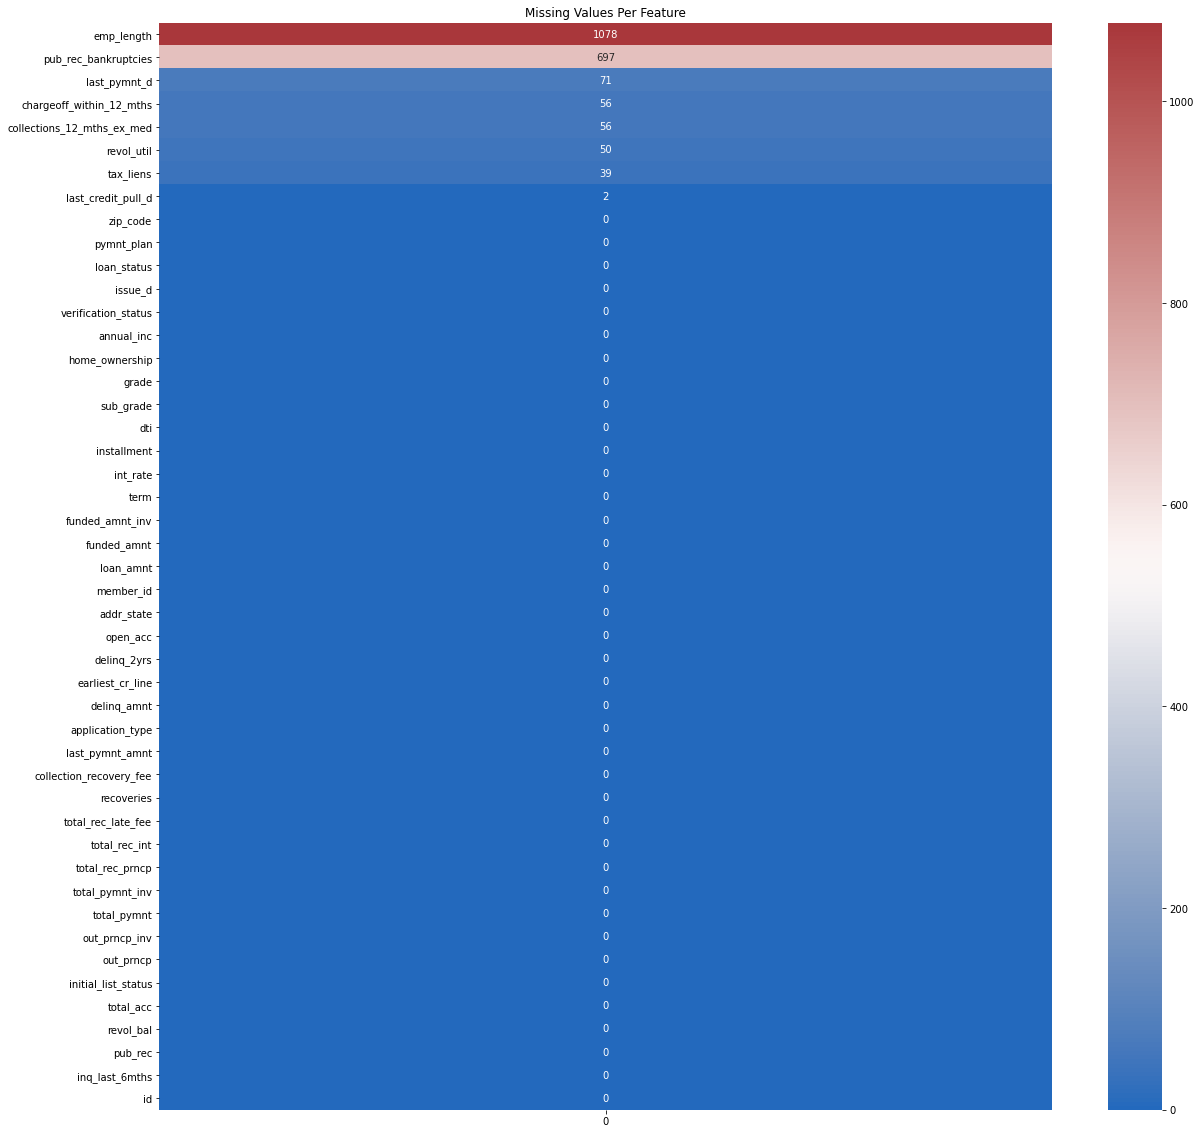

In [72]:
# heatmap - give a big picture of the missing values on the dataset.
plt.title('Missing Values Per Feature')
nans = df.isna().sum().sort_values(ascending=False).to_frame() # get NaN
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag') # seaborn

In [73]:
#df = df.dropna() # drop rows with NaN's
df.shape

(39786, 47)

In [74]:
# remove rows with missing data
#df = df.dropna()

# drop a column
# df.drop('column_name', axis=1)

#half_count = len(df) / 2  # 50% of the dataset
#df = df.dropna(thresh=half_count,axis=1) # Drop any column with more than 50% missing values

# Replace it by the mean, median or mode

In [75]:
df[list_columns_nan].head()

,emp_length,revol_util,last_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,chargeoff_within_12_mths,pub_rec_bankruptcies,tax_liens
0,10+ years,83.70%,Jan-15,Jan-17,0.0,0.0,0.0,0.0
1,< 1 year,9.40%,Apr-13,Oct-16,0.0,0.0,0.0,0.0
2,10+ years,98.50%,Jun-14,Jan-17,0.0,0.0,0.0,0.0
3,10+ years,21%,Jan-15,Apr-16,0.0,0.0,0.0,0.0
4,1 year,53.90%,Jan-17,Jan-17,0.0,0.0,0.0,0.0


In [76]:
# remove a special character on dataframe
df['revol_util'] = df['revol_util'].str.replace('%', '')
df['int_rate'] = df['int_rate'].str.replace('%', '')

# Convert object to float
df[['revol_util','int_rate']] = df[['revol_util','int_rate']].astype(float)

# convert obejcto category
list_cat = ['last_pymnt_d', 'last_credit_pull_d']

for ilist in list_cat:
    df[f'{ilist}'] = df[f'{ilist}'].astype('category')

In [77]:
df[list_cat]

,last_pymnt_d,last_credit_pull_d
0,Jan-15,Jan-17
1,Apr-13,Oct-16
2,Jun-14,Jan-17
3,Jan-15,Apr-16
4,Jan-17,Jan-17
...,...,...
39781,Jul-10,Jun-10
39782,Jul-10,Jul-10
39783,Apr-08,Jun-07
39784,Jan-08,Jun-07


In [78]:
df[list_columns_nan].dtypes

emp_length                      object
revol_util                     float64
last_pymnt_d                  category
last_credit_pull_d            category
collections_12_mths_ex_med     float64
chargeoff_within_12_mths       float64
pub_rec_bankruptcies           float64
tax_liens                      float64
dtype: object

In [79]:
# the mode replaces categorical data.
#mode = ''.join(df['emp_length'].mode())
#df['emp_length'].fillna(mode, inplace=True)

# datetime
#list_datetime = ['last_pymnt_d', 'last_credit_pull_d']

#for ilist in list_datetime:
#    mode = ''.join(df[f'{ilist}'].mode())
#    df[f'{ilist}'].fillna(mode, inplace=True)


# list columns float
#list_impute_mean = ['revol_util',
#                    'collections_12_mths_ex_med',
#                    'chargeoff_within_12_mths',
#                    'pub_rec_bankruptcies',
#                    'tax_liens'
#                   ]

# impute mean to missing values
#df = df.fillna(df[list_impute_mean].mean())

In [80]:
#df[list_columns_nan].dtypes

## Convert Feature (type: object) to Category

In [81]:
df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: x.astype('category'))

In [82]:
# instantiate labelencoder object
le = LabelEncoder()
categorical_cols = list(df.select_dtypes(['category']))

# apply le on categorical feature columns
df[categorical_cols] = df[categorical_cols].apply(lambda col: le.fit_transform(col))

In [83]:
df

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,application_type,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599,5000,5000,4975.0,0,10.65,162.87,1,6,...,0.00,43,171.62,46,0.0,0,0.0,0,0.0,0.0
1,1077430,1314167,2500,2500,2500.0,1,15.27,59.83,2,13,...,1.11,5,119.66,103,0.0,0,0.0,0,0.0,0.0
2,1077175,1313524,2400,2400,2400.0,0,15.96,84.33,2,14,...,0.00,61,649.91,46,0.0,0,0.0,0,0.0,0.0
3,1076863,1277178,10000,10000,10000.0,0,13.49,339.31,2,10,...,0.00,43,357.48,7,0.0,0,0.0,0,0.0,0.0
4,1075358,1311748,3000,3000,3000.0,1,12.69,67.79,1,9,...,0.00,45,67.30,46,0.0,0,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39781,92187,92174,2500,2500,1075.0,0,8.07,78.42,0,3,...,0.00,48,80.90,60,NaN,0,NaN,0,NaN,NaN
39782,90665,90607,8500,8500,875.0,0,10.28,275.38,2,10,...,0.00,48,281.94,50,NaN,0,NaN,0,NaN,NaN
39783,90395,90390,5000,5000,1325.0,0,8.07,156.84,0,3,...,0.00,0,0.00,57,NaN,0,NaN,0,NaN,NaN
39784,90376,89243,5000,5000,650.0,0,7.43,155.38,0,1,...,0.00,36,0.00,57,NaN,0,NaN,0,NaN,NaN


In [84]:
# get list for only dtypes 'int64 and 'float64'
list_columns = list(df.columns)

# Check for outliers
#for column in list_columns:
    #plt.figure()
    #sns.boxplot(x=df[f'{column}'])

In [85]:
list_columns_nan

['emp_length',
 'revol_util',
 'last_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'chargeoff_within_12_mths',
 'pub_rec_bankruptcies',
 'tax_liens']

## Dealing with Missing Data

In [86]:
for column in list_columns:
    mean = df[f'{column}'].mean()
    std = df[f'{column}'].std()
    
    if(mean == 0 and std == 0):
        # drop columns with zero for mean and standard devitation
        df = df.drop(columns=[f'{column}'])
        print(f"{column} - mean: {mean} std: {std}")

pymnt_plan - mean: 0.0 std: 0.0
initial_list_status - mean: 0.0 std: 0.0
collections_12_mths_ex_med - mean: 0.0 std: 0.0
application_type - mean: 0.0 std: 0.0
chargeoff_within_12_mths - mean: 0.0 std: 0.0
delinq_amnt - mean: 0.0 std: 0.0
tax_liens - mean: 0.0 std: 0.0


In [87]:
## Check if a distribution is close to the normal distribution

In [88]:
list_columns = list(df.columns)

# Check for outliers
for column in list_columns:
    mean = df[f'{column}'].mean()
    std = df[f'{column}'].std()

    #print(f"{column} - mean: {mean} std: {std}")
    stat, p = normaltest(df[f'{column}'])  # https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    
    # interpret
    alpha = 0.05

    for column_nan in list_columns_nan:
        if(column_nan == column):
            if(p > alpha):
                print(f'feature: {column} - Sample looks Gaussian (fail to reject H0)')
                df[f'{column}'] = df.fillna(df[f'{column}'].mean()) # inpute mean value 
            else:
                print(f'feature: {column} does not look Gaussian (reject H0)')
                df[f'{column}'] = df.fillna(df[f'{column}'].median()) # impute median value


Statistics=2464.955, p=0.000
Statistics=1358.349, p=0.000
Statistics=5639.522, p=0.000
Statistics=5975.516, p=0.000
Statistics=6281.038, p=0.000
Statistics=10787.293, p=0.000
Statistics=1116.740, p=0.000
Statistics=6641.942, p=0.000
Statistics=3253.413, p=0.000
Statistics=3293.204, p=0.000
Statistics=8617.363, p=0.000
feature: emp_length does not look Gaussian (reject H0)
Statistics=142360.206, p=0.000
Statistics=105209.605, p=0.000
Statistics=190907.930, p=0.000
Statistics=78354.908, p=0.000
Statistics=13979.262, p=0.000
Statistics=239055.348, p=0.000
Statistics=274579.787, p=0.000
Statistics=4314.064, p=0.000
Statistics=40287.935, p=0.000
Statistics=64346.279, p=0.000
Statistics=9893.264, p=0.000
Statistics=6233.357, p=0.000
Statistics=36348.196, p=0.000
Statistics=27470.510, p=0.000
Statistics=nan, p=nan
feature: revol_util does not look Gaussian (reject H0)
Statistics=3959.843, p=0.000
Statistics=151160.496, p=0.000
Statistics=151231.920, p=0.000
Statistics=9347.644, p=0.000
Statis

In [90]:
# After analyzing the columns and considering the model we’re 
# trying to build, we can conclude that the following 
# features can be removed:

features2removed = ['id', 'member_id', 'funded_amnt', 'funded_amnt_inv',
                    'sub_grade', 'int_rate']

df = df.drop(features2removed, axis=1)

In [91]:
print(f'Number of rows.....................: {df.shape[0]}')
print(f'Number of columns..................: {df.shape[1]}')

Number of rows.....................: 39786
Number of columns..................: 34


In [92]:
# count NaN found in the dataset
df.isna().sum()

loan_amnt                  0
term                       0
installment                0
grade                      0
emp_length                 0
home_ownership             0
annual_inc                 0
verification_status        0
issue_d                    0
loan_status                0
zip_code                   0
addr_state                 0
dti                        0
delinq_2yrs                0
earliest_cr_line           0
inq_last_6mths             0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                 0
total_acc                  0
out_prncp                  0
out_prncp_inv              0
total_pymnt                0
total_pymnt_inv            0
total_rec_prncp            0
total_rec_int              0
total_rec_late_fee         0
recoveries                 0
collection_recovery_fee    0
last_pymnt_d               0
last_pymnt_amnt            0
last_credit_pull_d         0
pub_rec_bankruptcies       0
dtype: int64

# Visualization - Columns

array([[<AxesSubplot:title={'center':'addr_state'}>,
        <AxesSubplot:title={'center':'annual_inc'}>,
        <AxesSubplot:title={'center':'collection_recovery_fee'}>,
        <AxesSubplot:title={'center':'delinq_2yrs'}>,
        <AxesSubplot:title={'center':'dti'}>,
        <AxesSubplot:title={'center':'earliest_cr_line'}>],
       [<AxesSubplot:title={'center':'emp_length'}>,
        <AxesSubplot:title={'center':'grade'}>,
        <AxesSubplot:title={'center':'home_ownership'}>,
        <AxesSubplot:title={'center':'inq_last_6mths'}>,
        <AxesSubplot:title={'center':'installment'}>,
        <AxesSubplot:title={'center':'issue_d'}>],
       [<AxesSubplot:title={'center':'last_credit_pull_d'}>,
        <AxesSubplot:title={'center':'last_pymnt_amnt'}>,
        <AxesSubplot:title={'center':'last_pymnt_d'}>,
        <AxesSubplot:title={'center':'loan_amnt'}>,
        <AxesSubplot:title={'center':'loan_status'}>,
        <AxesSubplot:title={'center':'open_acc'}>],
       [<AxesSub

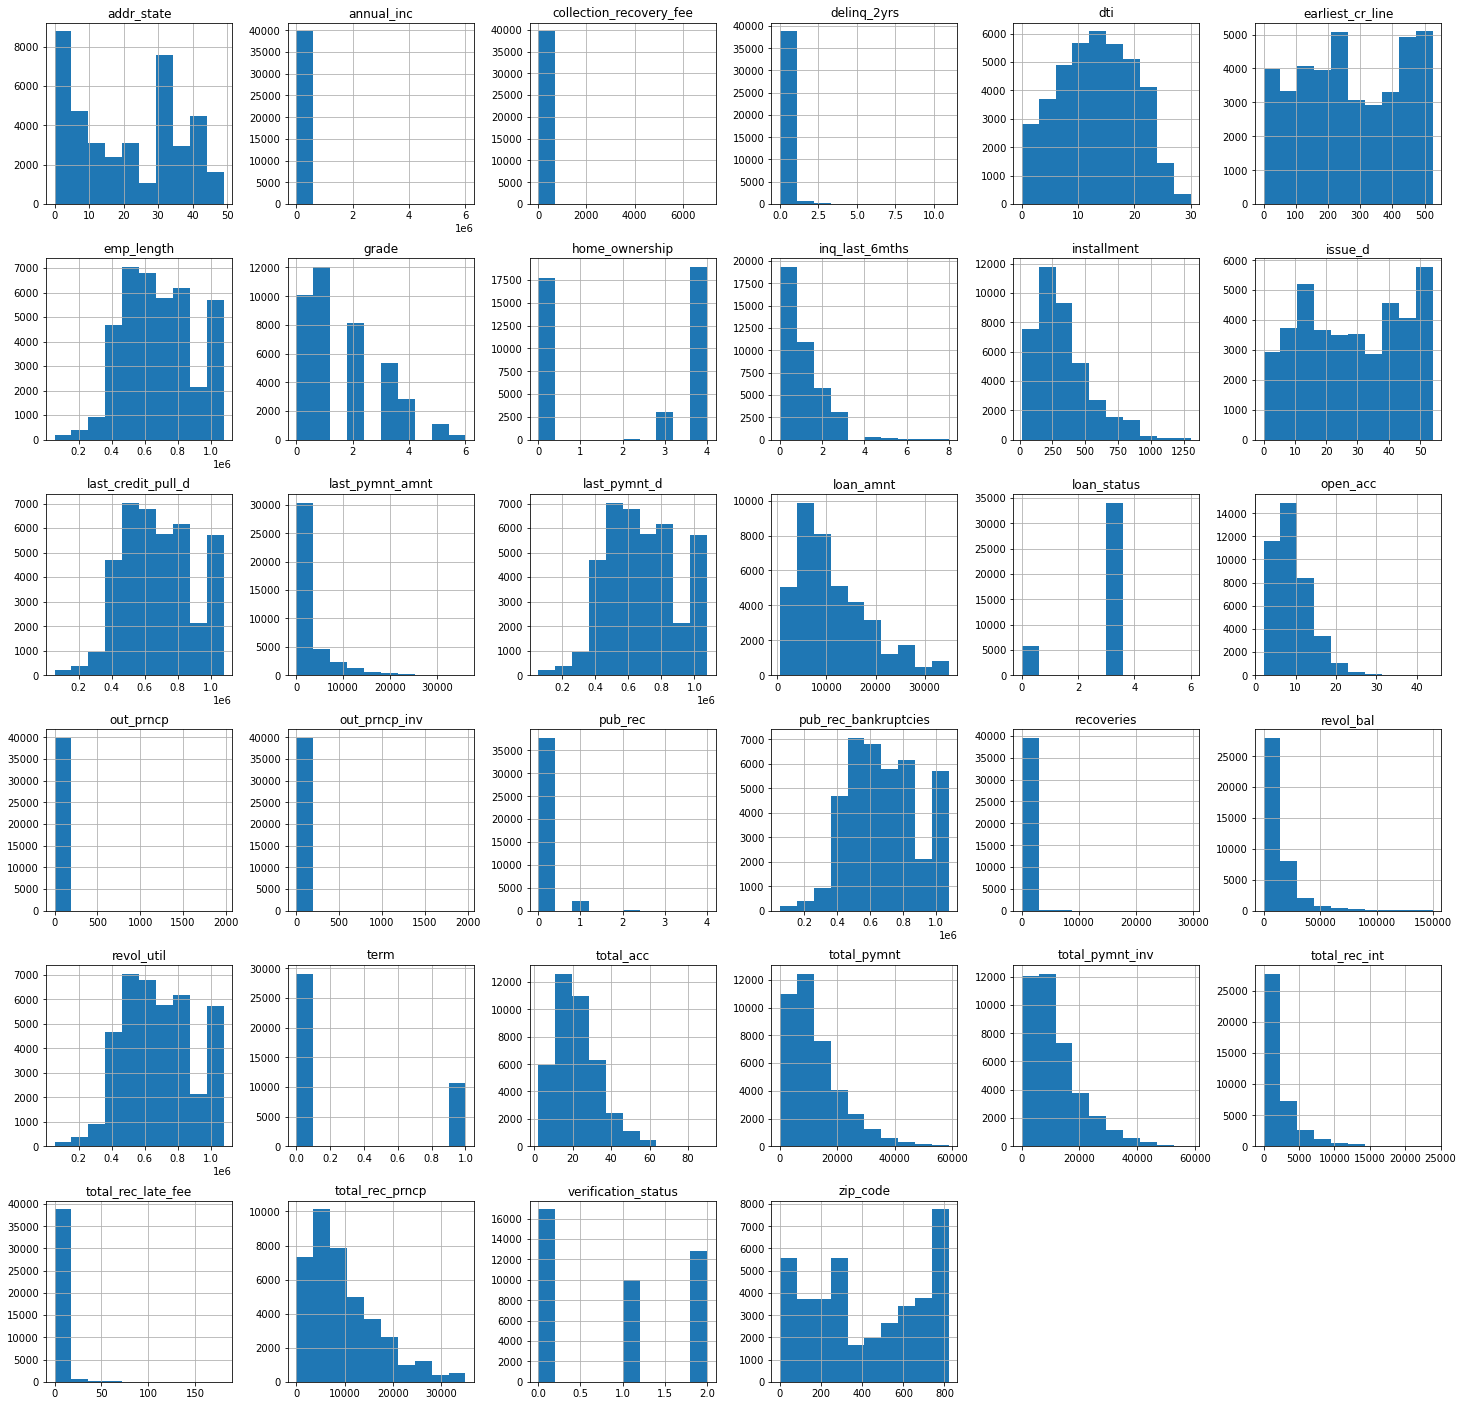

In [93]:
df.hist(figsize=(25, 25))

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39786 entries, 0 to 39785
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   loan_amnt                39786 non-null  int64  
 1   term                     39786 non-null  int64  
 2   installment              39786 non-null  float64
 3   grade                    39786 non-null  int64  
 4   emp_length               39786 non-null  float64
 5   home_ownership           39786 non-null  int64  
 6   annual_inc               39786 non-null  float64
 7   verification_status      39786 non-null  int64  
 8   issue_d                  39786 non-null  int64  
 9   loan_status              39786 non-null  int64  
 10  zip_code                 39786 non-null  int64  
 11  addr_state               39786 non-null  int64  
 12  dti                      39786 non-null  float64
 13  delinq_2yrs              39786 non-null  int64  
 14  earliest_cr_line      

In [95]:
#df_ocean_proximity_cat = df['ocean_proximity'].value_counts(normalize=True).map('{:.2%}'.format)
#ex.pie(df_ocean_proximity_cat,names='ocean_proximity',title='ocean_proximity')

In [96]:
df.head()

,loan_amnt,term,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,...,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies
0,5000,0,162.87,1,1077501.0,4,24000.0,2,13,3,...,5833.84,5000.00,863.16,0.00,0.0,0.00,1077501.0,171.62,1077501.0,1077501.0
1,2500,1,59.83,2,1077430.0,4,30000.0,1,13,0,...,1014.53,456.46,435.17,0.00,122.9,1.11,1077430.0,119.66,1077430.0,1077430.0
2,2400,0,84.33,2,1077175.0,4,12252.0,0,13,3,...,3005.67,2400.00,605.67,0.00,0.0,0.00,1077175.0,649.91,1077175.0,1077175.0
3,10000,0,339.31,2,1076863.0,4,49200.0,1,13,3,...,12231.89,10000.00,2214.92,16.97,0.0,0.00,1076863.0,357.48,1076863.0,1076863.0
4,3000,1,67.79,1,1075358.0,4,80000.0,1,13,3,...,4066.91,3000.00,1066.91,0.00,0.0,0.00,1075358.0,67.30,1075358.0,1075358.0


In [97]:
# Exploring it and understanding what feature each column represents.

# data dictionary 
data_dictionary = pd.read_csv('../data/LCDataDictionary.csv') # Loading in the data dictionary
#print(data_dictionary.shape[0])
#print(data_dictionary.columns.tolist())


In [98]:
data_dictionary = data_dictionary.dropna()

list_columns_all = list(df.columns)

ii = 1
for index, row in data_dictionary.iterrows():
       col1 = row['LoanStatNew']
       col2 = row['Description']

       for icol in list_columns_all:
            if(col1 == icol):
               print(f'# {ii} - {col1}: .......{col2}')
               ii = ii+1

# 1 - addr_state: .......The state provided by the borrower in the loan application
# 2 - annual_inc: .......The self-reported annual income provided by the borrower during registration.
# 3 - collection_recovery_fee: .......post charge off collection fee
# 4 - delinq_2yrs: .......The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
# 5 - dti: .......A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
# 6 - earliest_cr_line: .......The month the borrower's earliest reported credit line was opened
# 7 - emp_length: .......Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 
# 8 - grade: .......LC assigned loan grade
# 9 - home_ownership: .......The home ownership status provided by the borrower during registr

In [99]:
# Generates profile reports from a pandas DataFrame
# pandas_profiling extends the pandas DataFrame with 
# df.profile_report() for quick data analysis
# This request a lot of memory RAM.
# Pandas Profiling on github: https://github.com/pandas-profiling/pandas-profiling
profile = ProfileReport(df, title="Pandas Profiling Report")

In [100]:
# report format html
# A nice way to explore the data. Take a look :)
#!mkdir reports

#profile.to_file("reports/index.html")

# open reports/lending_club_loans.html in a browser

In [101]:
print("saving the file format feather...")

# this is important to do before save in feather format.
df = df.reset_index(drop=True) # reset index pandas before save feather format
df.to_feather('../data/dataset_cleaning.ftr') # save to feather format

release_memory(df)

saving the file format feather...
memory RAM released.


In [102]:
# time of execution in minutes
time_exec_min = round( (time.time() - start_time)/60, 4)

print(f'time of execution (preprocessing/cleaning): {time_exec_min} minutes')
print("the preprocessing is done.")
print("The next step is to do the feature engineering.")
# datetime object containing current date and time
now = datetime.now()

# dd/mm/YY H:M:S
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print(">>> date: ", dt_string)

print("All Done. :)")

time of execution (preprocessing/cleaning): 1.3306 minutes
the preprocessing is done.
The next step is to do the feature engineering.
>>> date:  05/08/2021 22:30:11
All Done. :)
